In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from collections import namedtuple

from utils.batch_generator import BatchGenerator

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

In [1]:
UNET_RESULTS = './results/unet/results_loss.txt'

In [34]:
results_loss = pd.read_csv(UNET_RESULTS,index_col='epoch')

In [35]:
results_loss.head()

,eval_train_loss,added_col_1,eval_validation_loss,added_col_2,batch_train_loss,batch_val_loss,batch_stats_train_avg_loss,batch_stats_train_std_loss,batch_stats_val_avg_loss,batch_stats_val_std_loss
epoch,,,,,,,,,,
0,[0.2739757299423218,0.7470660209655762],[0.30065637826919556,0.7182803153991699],0.252934,0.281720,0.251124,0.055732,0.278450,0.073623
1,[0.14640292525291443,0.8443968296051025],[0.15980924665927887,0.8404857516288757],0.155603,0.159514,0.155437,0.017388,0.159157,0.025498
2,[0.09984351694583893,0.8769188523292542],[0.12257271260023117,0.8480308055877686],0.123081,0.151969,0.122980,0.013658,0.150408,0.052771
3,[0.13026535511016846,0.8587062358856201],[0.1268918216228485,0.8489619493484497],0.141294,0.151038,0.140950,0.024978,0.149712,0.048502
4,[0.0714511051774025,0.9160361886024475],[0.08749495446681976,0.9057915806770325],0.083964,0.094209,0.083622,0.025402,0.094026,0.018598


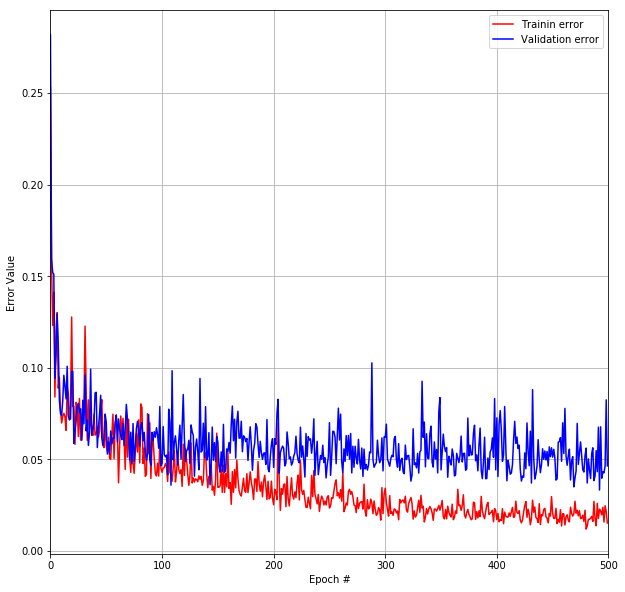

In [63]:
plt.plot(results_loss.index, results_loss.batch_train_loss, 'r', label='Trainin error')
plt.plot(results_loss.index, results_loss.batch_val_loss, 'b', label='Validation error')
plt.legend()
plt.grid()
plt.xlim((0, 500))
plt.xlabel('Epoch #')
plt.ylabel('Error Value')
plt.show()

In [64]:
from networks.unet import Unet
from keras.models import Model

In [65]:
LUNGS_IMGS = './dataset/lungs_segmentation/lungs_resized/'
LUNGS_MASKS = './dataset/lungs_segmentation/masks_dilated_resized/'

In [71]:
files = pd.read_csv('./dataset/lungs_segmentation/files_names.csv')
files['image_path'] = ['{}{}'.format(LUNGS_IMGS, file_name) for file_name in files.file_name.values]
files['mask_path'] = ['{}{}'.format(LUNGS_MASKS, file_name) for file_name in files.file_name.values]
BATCH_SIZE = 6
IMG_ROWS, IMG_COLS = 256, 256
SAVE_MODEL_DIR = './models/'
RESULTS_FILE = 'results.txt'
VAL_BATCH=5

In [72]:
batch_gen = BatchGenerator(
    data=files, validate=0.2, batch_size=BATCH_SIZE
)

In [69]:
_, (samples_x, samples_y) = batch_gen.generate_test_batch(6)

In [70]:
imgs_pos = [i for i in range(1, 13, 2)]
masks_pos = [i for i in range(2, 13, 2)]

In [73]:
model = Unet.model(IMG_ROWS, IMG_COLS)

In [74]:
model.load_weights('./results/unet/deep_unet_batch_1_epoch_100.hdf5')

In [75]:
imgs_pos = [i for i in range(1, 19, 3)]
masks_pos = [i for i in range(2, 19, 3)]
masks_gen_pos = [i for i in range(3, 19, 3)]

In [76]:
gen_masks = model.predict(samples_x)

(-0.5, 255.5, 255.5, -0.5)

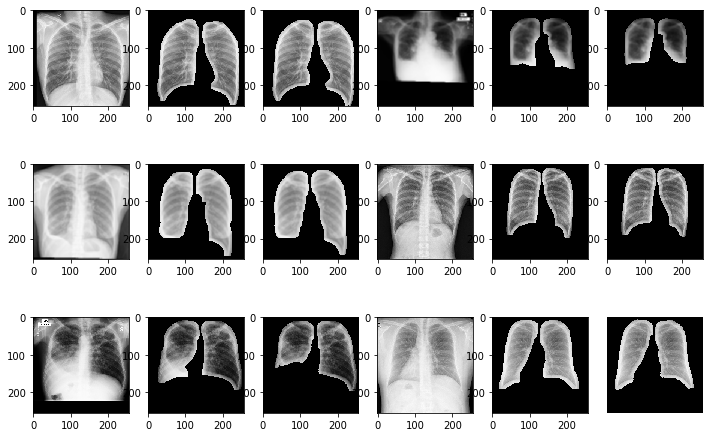

In [104]:
plt.figure(figsize=(12,8))
for (pos, img_pos, mask_pos, mask_gen_pos) in zip(range(6), imgs_pos, masks_pos, masks_gen_pos):
    
    plt.subplot(3, 6, img_pos)
    img = samples_x[pos].astype(np.uint8)
    plt.imshow(img)
    
    plt.subplot(3, 6, mask_pos)
    mask = samples_y[pos].astype(np.uint8)
    mask = mask.reshape(mask.shape[:2])# * 255
    mask = img * mask[..., np.newaxis]
    plt.imshow(mask)
    
    plt.subplot(3, 6, mask_gen_pos)
    mask_gen = gen_masks[pos].reshape(256, 256, 2) * 255
    mask_gen = mask_gen.astype(np.uint8)
    mask_gen[mask_gen < 127] = 0
    mask_gen[mask_gen >= 127] = 1
    mask_gen = img * mask_gen[..., 1, np.newaxis]
    plt.imshow(mask_gen)
plt.axis('off')